In [1]:
import numpy as np
from scipy.ndimage import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.hub
import torch.utils.data as Data

from torchvision.datasets import *
import torchvision
import torchvision.transforms as transforms

# from torchsummary import summary
# import tensorboardX as tbx
# from tensorboardX import SummaryWriter

import random
import os
import time
import datetime
from PIL import *
# import cv2
# from cv2 import *

import argparse

from utility.output import *
from utility.metrics import computeMetrics
from utility.network_process import net_freeze_layer
from utility.plot import plotResultCurve
# from utility.edataset import *

In [2]:
torch.cuda.is_available()

True

In [3]:
# p = argparse.ArgumentParser()

# p.add_argument("--EPOCH", type=int, default=20)
# p.add_argument("--BATCH_SIZE", type=int, default=6)
# p.add_argument("--CV", type=int, default=5)
# p.add_argument("--NUM_CLASS", type=int, default=4)
# p.add_argument("--SCHEDULE_EPOCH", type=int, default=5)
# p.add_argument("--SCHEDULE_REGRESS", type=int, default=0.2)
# p.add_argument("--PARTIAL_TRAIN", action="store_true", default=False)
# p.add_argument("--PARTIAL_TRAIN_RATIO", type=float, default=0.003)
# p.add_argument("--NET_FREEZE", action="store_true", default=False)
# p.add_argument("--train_ratio", type=float, default=0.7)
# p.add_argument("--init_lr", type=float, default=1e-3)

# args = p.parse_args()

# EPOCH = args.EPOCH
# BATCH_SIZE = args.BATCH_SIZE
# NUM_CLASS = args.NUM_CLASS
# CV = args.CV

# SCHEDULE_EPOCH = args.SCHEDULE_EPOCH
# SCHEDULE_REGRESS = args.SCHEDULE_REGRESS

# ### 部分训练
# _PARTIAL_TRAIN = args.PARTIAL_TRAIN
# _PARTIAL_TRAIN_RATIO = args.PARTIAL_TRAIN_RATIO

# ### 冻结网络
# _NET_FREEZE = args.NET_FREEZE
# _NET_NO_GRAD = []

# P_lr = args.init_lr
# train_ratio = args.train_ratio 

In [3]:
#### 模型保存文件路径
WORK_DIR = r'/root/research/jupyter/git-metallic-5-5/metallic'
MODEL_SAVE_PATH = WORK_DIR+'/model'
isServer = True
#### 数据路径
if isServer:
    DATA_PATH = r'/root/research/jupyter/git-metallic-5-5/metallic/traindata'
else:
    DATA_PATH = r'E:\buffer\dataset\train'


# 定义Summary_Writer
# tensorboard --logdir=D:\IDE\MyProject\python\jupyter_notebook\Research\git-metallic\metallic\log_res
# writer = SummaryWriter(log_dir='./log_res',comment='resnet18')   # 数据存放在这个文件夹
# writer.export_scalars_to_json("./log_res/all_scalars.json")
# writer.close()

In [3]:
def getCurrentTime():
    return datetime.datetime.strftime(datetime.datetime.fromtimestamp(time.time()),format='%Y-%m-%d-%H-%M-%S')

#### 模型保存
def checkpoint(model, optimizer, epoch, useTimeDir=False):
    # 保存整个模型  
    state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}
    model_name = str(model).split('(')[0]
    if useTimeDir is True:
        savePath = MODEL_SAVE_PATH+'/'+getCurrentTime()
        os.mkdir(savePath)
    else:
        savePath = MODEL_SAVE_PATH
    dir = os.path.join(savePath,model_name+'_model.pth')
    torch.save(state, dir)
    return savePath if useTimeDir else None

#### 模型恢复
def modelrestore(model):
    model_name = str(model).split('(')[0]
    dir = os.path.join(MODEL_SAVE_PATH,model_name+'_model.pth')
    checkpoint = torch.load(dir)
    model.load_state_dict(checkpoint['net'])
    epoch = checkpoint['epoch'] + 1
    return model, epoch


def saveParameters(root_path):
    params = {
        'EPOCH': EPOCH,
        'BATCH_SIZE': BATCH_SIZE,
        'NUM_CLASS': NUM_CLASS,
        'CV': CV,
        'SCHEDULE_EPOCH': SCHEDULE_EPOCH,
        'SCHEDULE_REGRESS': SCHEDULE_REGRESS,
        '_PARTIAL_TRAIN': _PARTIAL_TRAIN,
        '_PARTIAL_TRAIN_RATIO': _PARTIAL_TRAIN_RATIO,
        '_NET_FREEZE': _NET_FREEZE,
        '_NET_NO_GRAD':  _NET_NO_GRAD,
        'P_lr': P_lr,
        'train_ratio': train_ratio,
        'NET_NAME':NET_NAME,
    }
    with open(os.path.join(root_path,'params.txt'),'w+') as f:
        json.dump(params,f)
    print('parameters stored')
    return

def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:
        count[item[1]-1] += 1
    weight_per_class = [0.] * nclasses                                      
    N = float(len(images))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = ( N/float(count[i]) if count[i]!=0 else 0 )                               
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]-1]                                  
    return weight

In [6]:
EPOCH = 10
BATCH_SIZE = 150
NUM_CLASS = 4
CV = 1

SCHEDULE_EPOCH = 10
SCHEDULE_REGRESS = 0.3

### 部分训练
_PARTIAL_TRAIN = False
_PARTIAL_TRAIN_RATIO = 0.01

### 冻结网络
_NET_FREEZE = False
_NET_NO_GRAD = []

NET_NAME = 'se_resnet50'

P_lr = 1e-3
train_ratio = 0.8

augment_ratio = 0.99

#### image transformation for original images
data_transform_origin = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])

#### image transformation for augmented images
data_transform_aug = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(0.7),
    transforms.RandomVerticalFlip(0.7),
    transforms.ToTensor(),
#     transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])


# full_dataset = ImageFolder(DATA_PATH,transform = data_transform)


class EDataset(Data.Dataset):

    def __init__(self, root_path, basic_transform, aug_transform, aug_ratio=0.3):
        self.root_path = root_path
        self.basic_transform = basic_transform
        self.aug_transform = aug_transform
        self.image_origin = ImageFolder(self.root_path,
                                        transform = self.basic_transform)
        self.image_augment = ImageFolder(self.root_path,
                                        transform = self.aug_transform)
        self.len_origin = len(self.image_origin)
        self.len_augment = int(len(self.image_augment)*aug_ratio)
        self.idx_augment = np.random.permutation(len(self.image_augment))
        return

    def __len__(self):
        return self.len_origin + self.len_augment

    def __getitem__(self, idx):
        if idx<self.len_origin:
            item = self.image_origin[idx]
        else:
            item = self.image_augment[ self.idx_augment[idx-self.len_origin] ]
        return item

    
def getModel(NUM_CLASS,name='se_resnet50'):
    return torch.hub.load(
            'moskomule/senet.pytorch',
            name,
            num_classes=NUM_CLASS
    )



full_dataset = ImageFolder(DATA_PATH,transform = data_transform_aug)


total_size = len(full_dataset)

_metrics = []
_metrics_train = []
epoch_save = 0

for cv in range(CV):
    
    hub_model = getModel(NUM_CLASS=NUM_CLASS,name=NET_NAME)
    
    #### load model
    print('DEBUG:: fold ',cv)
    try:
        hub_model, epo = modelrestore(hub_model)
        print('Model successfully loaded')
        print('-' * 60)
    except Exception as e:
        print('Model not found, use the initial model')
        epo = 0
        print('-' * 60)
        
    net = hub_model
    
    #### define criterian & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=P_lr)
    scheduler = lr_scheduler.StepLR(optimizer, SCHEDULE_EPOCH, SCHEDULE_REGRESS)
    
    #### use CUDA if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    
    #### data splitting
    if _PARTIAL_TRAIN:
        full_dataset, _ = torch.utils.data.random_split(full_dataset, 
                                                        [
                                                            int(_PARTIAL_TRAIN_RATIO*total_size),
                                                            total_size - int(_PARTIAL_TRAIN_RATIO*total_size) 
                                                        ])
        total_size = int(_PARTIAL_TRAIN_RATIO*total_size)
        
    train_size = int(np.floor( total_size * train_ratio ))
    test_size = int(total_size - train_size)
#     dataset_train, dataset_test = torch.utils.data.random_split(full_dataset, [train_size,test_size])
    
    #### training
    _loss = []
    __record_train_num = 0
    epoch_save = epo
    for epoch in range(epo, EPOCH):  # loop over the dataset multiple times
        epoch_save += 1
        print('DEBUG:: training epoch ',epoch)
        
        weights = make_weights_for_balanced_classes(full_dataset.imgs, NUM_CLASS)                                                                
        weights = torch.DoubleTensor(weights)                                       
        sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
        
#         trainloader = Data.DataLoader(dataset=dataset_train.dataset, batch_size=BATCH_SIZE, sampler=sampler_train)
#         testloader = Data.DataLoader(dataset=dataset_test.dataset, batch_size=BATCH_SIZE, sampler=sampler_test)

        dataloader = Data.DataLoader(dataset=full_dataset, batch_size=BATCH_SIZE, sampler=sampler)
        total_batch = len(dataloader)
        train_batch = int(train_ratio*total_batch)
        
        
        Ytrain = []
        Ylabels = []
        running_loss = 0.0
        start_time = time.time()
        for data,i in zip(dataloader, range(train_batch)):
            
            #### get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #### zero the parameter gradients
            optimizer.zero_grad()
            #### forward + backward + optimize
            outputs = net(inputs)
            
            _, predicted = torch.max(outputs, 1)
            Ylabels.extend(labels.tolist())
            Ytrain.extend(predicted.tolist())
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #### print statistics
            running_loss += loss.item()
            _loss.append(running_loss)
            
            __record_train_num += len(labels)
            if __record_train_num % (BATCH_SIZE * 50) == 0:
                print('DEBUG:: num has trained',__record_train_num)
            if i % 50 == 0:
                end_time = time.time()
                print('DEBUG:: time elapsed ',(end_time-start_time)/60)
                print('DEBUG:: trainloader:{}/{}'.format(i, train_batch))
                start_time = time.time()
            if i % 500 == 0:
                try:
                    checkpoint(net, optimizer, epoch_save)
                    print('*' * 60)
                    print('Model is saved successfully at epoch {}'.format(str(epoch)))
                    print('*' * 60)
                except Exception as e:
                    print('*' * 60)
                    print('Something is wrong!',e)
                    print('*' * 60)
                    
        _metrics.append(computeMetrics(Ytrain,Ylabels))
                    
        #### predicting
        print('=' * 60)
        print('i:', i)
        print('Start predicting')
        Ypred = []
        Ytest = []
        with torch.no_grad():
            for data in dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                Ytest.extend(labels.tolist())
                Ypred.extend(predicted.tolist())

        _metrics.append(computeMetrics(Ypred,Ytest))
        print("accuracy is {}".format(_metrics[-1]['acc']) )
        print('=' * 60)
    

print('-' * 60)
print('Training is over, saving the model')
print('-' * 60)
try:
    savePath = checkpoint(net, optimizer, epoch_save, useTimeDir=True)
    saveResult(_metrics,savePath)
    saveParameters(savePath)
    print('Model is saved successfully')
except Exception as e:
    print('Something is wrong!',e)
    raise e
    
    
    

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


DEBUG:: fold  0
Model not found, use the initial model
------------------------------------------------------------
DEBUG:: training epoch  0
DEBUG:: time elapsed  0.017666133244832356
DEBUG:: trainloader:0/410
************************************************************
Model is saved successfully at epoch 0
************************************************************
DEBUG:: num has trained 7500
DEBUG:: time elapsed  0.8607938806215922
DEBUG:: trainloader:50/410
DEBUG:: num has trained 15000
DEBUG:: time elapsed  0.8292129476865132
DEBUG:: trainloader:100/410
DEBUG:: num has trained 22500
DEBUG:: time elapsed  0.813215188185374
DEBUG:: trainloader:150/410
DEBUG:: num has trained 30000
DEBUG:: time elapsed  0.8183675090471904
DEBUG:: trainloader:200/410
DEBUG:: num has trained 37500
DEBUG:: time elapsed  0.8132898569107055
DEBUG:: trainloader:250/410
DEBUG:: num has trained 45000
DEBUG:: time elapsed  0.8023882150650025
DEBUG:: trainloader:300/410
DEBUG:: num has trained 52500
DEBUG::

/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


accuracy is 0.6856970606970607
DEBUG:: training epoch  1
DEBUG:: time elapsed  0.015905133883158364
DEBUG:: trainloader:0/410
************************************************************
Model is saved successfully at epoch 1
************************************************************
DEBUG:: num has trained 67500
DEBUG:: time elapsed  0.8256241798400878
DEBUG:: trainloader:50/410
DEBUG:: num has trained 75000
DEBUG:: time elapsed  0.7806846380233765
DEBUG:: trainloader:100/410
DEBUG:: num has trained 82500
DEBUG:: time elapsed  0.7793215632438659
DEBUG:: trainloader:150/410
DEBUG:: num has trained 90000
DEBUG:: time elapsed  0.7779691775639852
DEBUG:: trainloader:200/410
DEBUG:: num has trained 97500
DEBUG:: time elapsed  0.7775259256362915
DEBUG:: trainloader:250/410
DEBUG:: num has trained 105000
DEBUG:: time elapsed  0.7791730920473735
DEBUG:: trainloader:300/410
DEBUG:: num has trained 112500
DEBUG:: time elapsed  0.7757476051648458
DEBUG:: trainloader:350/410
DEBUG:: num has tra

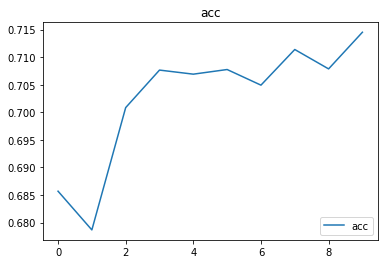

In [5]:
#### plotting
_metrics = json.load(open(WORK_DIR+'/model/2020-05-10-17-03-02/scores.txt','r+'))
plotResultCurve(_metrics,['acc'],'acc')
# plotResultCurve(_metrics,['fpr','tpr'],' fpr-tpr')


处理

In [20]:
def RemoveImgInFolder(path_dir, ratio):
    # path文件夹路径，ratio删除比例
    filelist = os.listdir(path_dir)
    rmfilelist = random.sample(filelist, int(ratio*len(filelist)))
    for idx,f in enumerate(rmfilelist):
        filepath = os.path.join(path_dir, f)
        if os.path.isfile(filepath):
            os.remove(filepath)
            if idx%1000==1:
                print('remove ',idx)
    return

def ImgSummary(path_dirs):
    filelists = [ os.listdir(x) for x in path_dirs ]
    _ = [print(p,len(x)) for x,p in zip(filelists,path_dirs)]
    return

In [9]:
# ImgSummary([WORK_DIR+'/traindata/0'])
# RemoveImgInFolder(WORK_DIR+'/traindata/0',ratio=0.887)

In [5]:
weights = make_weights_for_balanced_classes(dataset_train.dataset.imgs, NUM_CLASS)                                                                
weights = torch.DoubleTensor(weights)                                       
sampler_train = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

# weights = make_weights_for_balanced_classes(dataset_test.dataset.imgs, NUM_CLASS)                                                                
# weights = torch.DoubleTensor(weights)                                       
# sampler_test = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [33]:
_ = [print(x,y) for x,y in zip([1,2,3],range(2))]

1 0
2 1
